In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_cifar_test_files function

from generate_input_files.generate_cifar_test_files import generate_cifar_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_epochs_test")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "performance", "increasing_epochs_test")

# Step 1: Generate CIFAR-10 test files
print("Generating CIFAR-10 test files...")
generated_files = generate_cifar_test_files(tmp_folder)
print("File generation completed.")

# Extract file paths
dataset_filename = generated_files["dataset"]
yaml_filename = generated_files["yaml"]
model_filename = generated_files["model"]

Generating CIFAR-10 test files...
CIFAR-10 images saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset (max 500 per class)
Dataset definition saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_definition.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_dataset.zip
Model saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_epochs_test\cifar10_model.keras
File generation completed.


In [3]:
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the epoch counts to test
epoch_counts = [1, 2, 5, 10, 50, 100]
epoch_mapping = {}  # Dictionary to map epochs to unique_dir and job_id

# Step 2: Submit jobs with increasing epochs
for epochs in epoch_counts:
    print(f"\nSubmitting job with {epochs} epochs...")

    # Prepare the files and data for the request
    files = {
        "model": open(model_filename, "rb"),
        "dataset": open(dataset_filename, "rb"),
        "dataset_definition": open(yaml_filename, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"performance_analysis_model_{epochs}_epochs",
        "epochs": epochs,
    }

    # Submit the job
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted: {response.status_code} {response.text}")

    # Extract the unique_dir and job_id from the API response
    response_data = response.json()
    unique_dir = response_data.get("unique_dir")
    job_id = response_data.get("job_id")  # Assuming the API returns a job_id
    if not unique_dir:
        raise ValueError("Error: 'unique_dir' not found in the API response.")

    # Store the mapping
    epoch_mapping[epochs] = {"unique_dir": unique_dir, "job_id": job_id}

    # Wait for the job to finish and download the results
    print(f"Waiting for job with {epochs} epochs to complete...")
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
    print(f"Artifacts for {epochs} epochs downloaded to: {DOWNLOAD_DIR}")


Submitting job with 1 epochs...
Submitted: 200 {"job_id":"47331a01-064a-42fa-9f3d-647d3e994f31","status":"Training started","unique_dir":"ccc35e44-48a1-443d-bec9-560acc630f97"}
Waiting for job with 1 epochs to complete...
Checking if job is finished by looking for 'output' folder in 'ccc35e44-48a1-443d-bec9-560acc630f97'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'ccc35e44-48a1-443d-bec9-560acc630f97'...
Downloaded: ccc35e44-48a1-443d-bec9-560acc630f97/dataset/cifar10_dataset.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ccc35e44-48a1-443d-bec9-560acc630f97/dataset/cifar10_dataset.zip
Downloaded: ccc35e44-48a1-443d-bec9-560acc630f97/definition/cifar10_definition.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ccc35e44-48a1-443d-bec9-560acc630f97/definitio

In [4]:
import os
from datetime import datetime

# Define the path to the job result folders
results_dir = DOWNLOAD_DIR  # Use the DOWNLOAD_DIR defined earlier
log_filename = "logs.log"  # Name of the log file in each job folder

# Function to parse a timestamp string into a datetime object
def parse_log_timestamp(timestamp_str):
    return datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S,%f")

# Function to extract timings from a log file
def extract_timings_from_log(log_file_path):
    timings = {}
    with open(log_file_path, "r") as log_file:
        for line in log_file:
            if "Training started at UTC" in line:
                timings["training_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "AIBoM generation started at UTC" in line:
                timings["aibom_start"] = parse_log_timestamp(line.split(" - ")[0])
            elif "Task completed successfully" in line:
                timings["task_complete"] = parse_log_timestamp(line.split(" - ")[0])
    return timings

# Process each job folder
job_folders = [os.path.join(results_dir, folder) for folder in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, folder))]
job_timings = []  # Use a list to store job timings

for epochs, info in epoch_mapping.items():
    unique_dir = info["unique_dir"]
    job_folder = os.path.join(results_dir, unique_dir)
    log_file_path = os.path.join(job_folder, "output", log_filename)
    
    if os.path.exists(log_file_path):
        print(f"Processing log file for epoch {epochs}: {log_file_path}")
        timings = extract_timings_from_log(log_file_path)
        if "training_start" in timings and "aibom_start" in timings and "task_complete" in timings:
            training_duration = (timings["aibom_start"] - timings["training_start"]).total_seconds()
            aibom_duration = (timings["task_complete"] - timings["aibom_start"]).total_seconds()
            total_duration = (timings["task_complete"] - timings["training_start"]).total_seconds()
            job_timings.append({
                "epochs": epochs,
                "training_start": timings["training_start"],
                "training_duration": training_duration,
                "aibom_duration": aibom_duration,
                "total_duration": total_duration,
            })
        else:
            print(f"Warning: Missing timestamps in {log_file_path}")
    else:
        print(f"Warning: Log file not found for epoch {epochs}")

# Sort the job timings by epochs
job_timings = sorted(job_timings, key=lambda x: x["epochs"])

# Print the sorted timings
print("\nExtracted Timings (Sorted by Epochs):")
for job in job_timings:
    print(f"Epochs: {job['epochs']}")
    print(f"  Training Start: {job['training_start']}")
    print(f"  Training Duration: {job['training_duration']} seconds")
    print(f"  AIBoM Duration: {job['aibom_duration']} seconds")
    print(f"  Total Duration: {job['total_duration']} seconds")
    print()

Processing log file for epoch 1: c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\ccc35e44-48a1-443d-bec9-560acc630f97\output\logs.log
Processing log file for epoch 2: c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\c2f6c19b-7c1d-4810-a782-1c2f2b2a1343\output\logs.log
Processing log file for epoch 5: c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\02b71f42-18e1-4f0e-8ce7-c6ba7db3882f\output\logs.log
Processing log file for epoch 10: c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\39bb6b22-55c1-44c8-967a-27c962ffe2bc\output\logs.log
Processing log file for epoch 50: c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\performance\increasing_epochs_test\b103b535-ddfa-40d4-b6

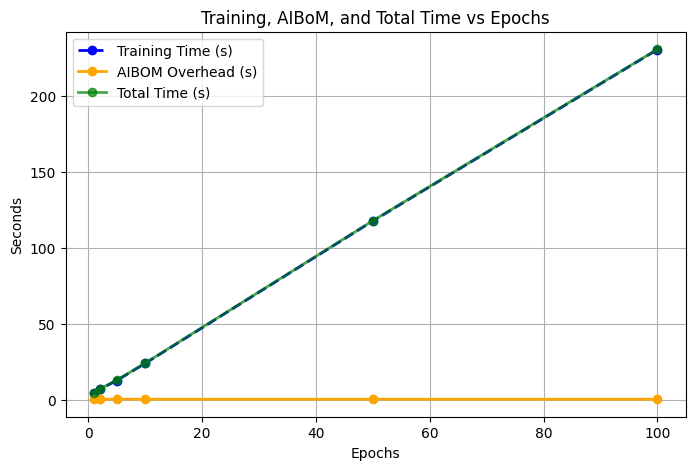

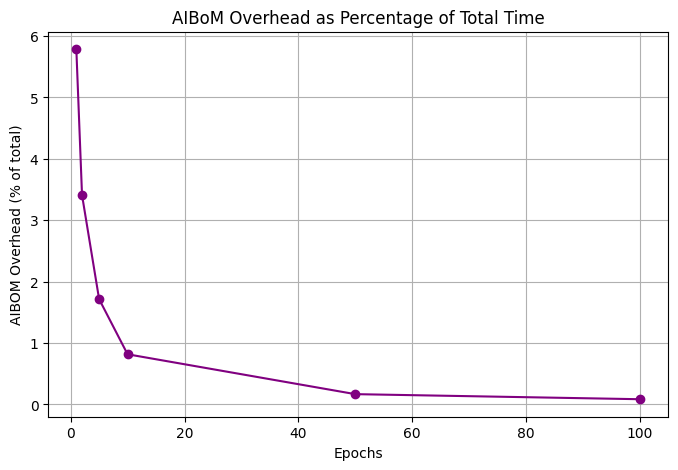

   Epochs  Training Time (s)  AIBOM Time (s)  Total Time (s)  \
0       1              4.316           0.265           4.581   
1       2              6.629           0.234           6.863   
2       5             12.492           0.218          12.710   
3      10             23.790           0.196          23.986   
4      50            117.728           0.198         117.926   
5     100            230.837           0.197         231.034   

   AIBOM Overhead (%)  
0            5.784763  
1            3.409588  
2            1.715185  
3            0.817143  
4            0.167902  
5            0.085269  


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract data for analysis
epochs_list = [job["epochs"] for job in job_timings]
training_times = [job["training_duration"] for job in job_timings]
aibom_times = [job["aibom_duration"] for job in job_timings]
total_times = [job["total_duration"] for job in job_timings]

# Plot Training Time vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs_list, training_times, marker='o', label='Training Time (s)', linestyle='--', color='blue', linewidth=2)
plt.plot(epochs_list, aibom_times, marker='o', label='AIBOM Overhead (s)', linestyle='-', color='orange', linewidth=2)
plt.plot(epochs_list, total_times, marker='o', label='Total Time (s)', linestyle='-', color='green', linewidth=2, alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True)
plt.title('Training, AIBoM, and Total Time vs Epochs')
plt.show()

# Plot AIBoM Overhead as Percentage of Total Time
overhead_pct = (np.array(aibom_times) / np.array(total_times)) * 100

plt.figure(figsize=(8, 5))
plt.plot(epochs_list, overhead_pct, marker='o', color='purple')
plt.xlabel('Epochs')
plt.ylabel('AIBOM Overhead (% of total)')
plt.grid(True)
plt.title('AIBoM Overhead as Percentage of Total Time')
plt.show()

# Print Table
df = pd.DataFrame({
    "Epochs": epochs_list,
    "Training Time (s)": training_times,
    "AIBOM Time (s)": aibom_times,
    "Total Time (s)": total_times,
    "AIBOM Overhead (%)": overhead_pct
})
print(df)